## Script to sample from pretrained riff-cnet model

Requires GPU. Best to Run in Google Colab. Just clone the entire github into your drive and pull the model from HuggingFace as directed below to make this work. Make sure you have set up the control condas environment as well.

In [ ]:
# UNCOMMENT AND RUN THIS BLOCK IF USING GOOGLE COLAB

from google.colab import drive
drive.mount("/content/drive/")

## cd into desired directory 
%cd drive/MyDrive/<my-directory>
%ls

# pull git repo 
# get training data
!git clone https://github.com/zachary-shah/riff-cnet.git
%cd riff-cnet

# even with the environment set up, you may need to install some other dependencies (run only if you get errors below)
!pip install Pillow==9.4.0
!pip install einops
!pip install omegaconf
#!pip install pytorch_lightning
!pip install transformers
!pip install open-clip-torch
!pip install pydub

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/<my-directory>'
/content
drive/  riff-cnet/  sample_data/
fatal: destination path 'riff-cnet' already exists and is not an empty directory.
/content/riff-cnet
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# load model from huggingface
!git lfs install
!git clone https://huggingface.co/zachary-shah/riffusion-cnet-v2

Updated git hooks.
Git LFS initialized.
fatal: destination path 'riffusion-cnet-v2' already exists and is not an empty directory.


In [ ]:
!git clone https://github.com/zachary-shah/riff-cnet.git

fatal: destination path 'riff-cnet' already exists and is not an empty directory.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch 
import einops 
from pytorch_lightning import seed_everything
import cv2
import os
from PIL import Image
import numpy as np
import random 

from riffusion.spectrogram_image_converter import SpectrogramImageConverter
from riffusion.spectrogram_converter import SpectrogramConverter
from riffusion.spectrogram_params import SpectrogramParams

from cldm.ddim_hacked import DDIMSampler
from cnet_riff_dataset import CnetRiffDataset
from cldm.model import create_model, load_state_dict

In [ ]:
!pip install pytorch_lightning==1.7.7 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# load model into pytorch 
mdl_path = "riffusion-cnet-v2/final_checkpoint.ckpt"
model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict(mdl_path, location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.2.layer_norm2.bias', 'vision_model.encoder.layers.14.self_attn.out_proj.weight', 'vision_model.embeddings.position_embedding.weight', 'vision_model.encoder.layers.5.self_attn.out_proj.bias', 'vision_model.encoder.layers.2.self_attn.q_proj.bias', 'vision_model.encoder.layers.7.self_attn.q_proj.bias', 'vision_model.encoder.layers.22.self_attn.out_proj.weight', 'vision_model.encoder.layers.9.mlp.fc1.weight', 'vision_model.encoder.layers.2.self_attn.k_proj.bias', 'vision_model.encoder.layers.22.layer_norm1.bias', 'vision_model.encoder.layers.7.mlp.fc2.weight', 'vision_model.encoder.layers.20.mlp.fc2.bias', 'vision_model.encoder.layers.17.self_attn.q_proj.weight', 'vision_model.encoder.layers.21.layer_norm1.bias', 'vision_model.encoder.layers.22.mlp.fc2.weight', 'vision_model.encoder.layers.7.layer_norm2.weight', 'vision_model.encoder.layers.11.s

Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [riffusion-cnet-v2/final_checkpoint.ckpt]


In [ ]:
# some helper functions needed

# image helper functions
def HWC3(x):
    assert x.dtype == np.uint8
    if x.ndim == 2:
        x = x[:, :, None]
    assert x.ndim == 3
    H, W, C = x.shape
    assert C == 1 or C == 3 or C == 4
    if C == 3:
        return x
    if C == 1:
        return np.concatenate([x, x, x], axis=2)
    if C == 4:
        color = x[:, :, 0:3].astype(np.float32)
        alpha = x[:, :, 3:4].astype(np.float32) / 255.0
        y = color * alpha + 255.0 * (1.0 - alpha)
        y = y.clip(0, 255).astype(np.uint8)
        return y
def resize_image(input_image, resolution):
    H, W, C = input_image.shape
    H = float(H)
    W = float(W)
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(np.round(H / 64.0)) * 64
    W = int(np.round(W / 64.0)) * 64
    img = cv2.resize(input_image, (W, H), interpolation=cv2.INTER_LANCZOS4 if k > 1 else cv2.INTER_AREA)
    return img

# helper function to sample the model
def sample_ddim(control, prompt, model,
                guess_mode = False,
                strength = 1,
                scale = 9,
                eta = 0,
                num_samples = 1,
                ddim_steps = 50,
                seed = -1,
                image_resolution = 512,
                log_every_t=100):

    with torch.no_grad():
        # preprocessing
        control = resize_image(HWC3(control), image_resolution)
        H, W, C = control.shape
        control = torch.from_numpy(control).float().cuda()
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        # to save memory
        model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([""] * num_samples)]}
        shape = (4, H // 8, W // 8)

        # to save memory
        model.low_vram_shift(is_diffusing=True)

        # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  
        
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                        shape, cond, verbose=False, eta=eta,
                                                        unconditional_guidance_scale=scale, log_every_t=log_every_t,
                                                        unconditional_conditioning=un_cond)

        # to save memory
        model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]

        return results, intermediates

In [ ]:
plt.imshow(test_dataset[i]['hint'])

INFO:pytorch_lightning.utilities.seed:Global seed set to 13169


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:33<00:00,  3.07s/it]


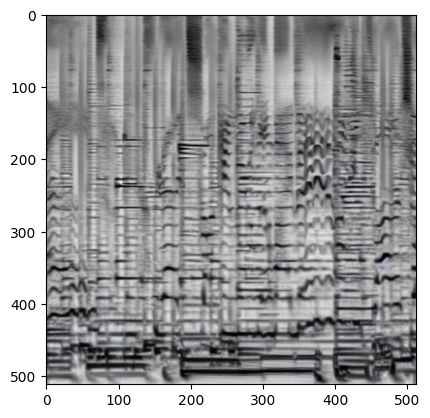

In [ ]:
# just get one sample from the dataset, and listen to example sample from cnet-riff
test_dataset = CnetRiffDataset("train-data/")
os.makedirs("samples", exist_ok=True)

i = 0
results, _ = sample_ddim(test_dataset[i]['hint'], test_dataset[i]['txt'], model, num_samples=4)
plt.imshow(results[0])
sample = results[0]

cv2.imwrite("samples/test_sample.png", sample)

img_converter_to_audio = SpectrogramImageConverter(SpectrogramParams(sample_rate=44100, min_frequency=0, max_frequency=10000))

sample_img = Image.open("samples/test_sample.png") 

out_audio_recon = img_converter_to_audio.audio_from_spectrogram_image(sample_img, apply_filters=True).set_channels(2)
out_audio_recon.export("test_sample.wav", format="wav")
out_audio_recon

In [ ]:
# now listen to target desired to compare to the sample generated (background is very similar but melody is different!)
target = (test_dataset[i]['jpg'] + 1) / 2 * 255
cv2.imwrite("samples/test_sample_target.png", target)
target_img = Image.open("samples/test_sample_target.png") 

out_audio_recon = img_converter_to_audio.audio_from_spectrogram_image(target_img, apply_filters=True).set_channels(2)
out_audio_recon.export("test_sample_target.wav", format="wav")
out_audio_recon

#### Splicing things

In [ ]:
import pydub
import cv2 as cv


x = pydub.AudioSegment.from_file("upbeatrockbackCONVERT.mp3", "mp3")

background = cv2.imread(".png")[:,256:]
first_256_frames = cv2.cvtColor(first_256_frames, cv2.COLOR_BGR2RGB)
first_256_frames_edges = cv.Canny(first_256_frames, 150, 200)
edges = np.stack((first_256_frames_edges,first_256_frames_edges,first_256_frames_edges),axis=-1)

img_left_area = (10000, 0, 10512, 512)
test_image_crop = test_image.crop(img_left_area)
from PIL import ImageFilter
#test_image_crop.filter(ImageFilter.FIND_EDGES)
A = np.asarray(test_image_crop.convert('RGB'))

#Get the first 5 seconds
test_image_crop = test_image.crop((0, 0, 512, 512))
test_image_crop = np.asarray(test_image_crop.convert('RGB'))


test_image_edges = cv.Canny(test_image_crop, 150, 200)
edges = np.stack((test_image_edges,test_image_edges,test_image_edges),axis=-1)
plt.imshow(edges)
results, _ = sample_ddim(edges, 'Generate an up-tempo female vocal rock melody', model, num_samples=4)
sample = results[0]

cv2.imwrite("/content/drive/MyDrive/Notebooks/EE 269 Final Project/full_Examples/0-first-5.png", sample)
img_converter_to_audio = SpectrogramImageConverter(SpectrogramParams(sample_rate=44100, min_frequency=0, max_frequency=10000))
sample_img = Image.open("/content/drive/MyDrive/Notebooks/EE 269 Final Project/full_Examples/0-first-5.png") 
out_audio_recon = img_converter_to_audio.audio_from_spectrogram_image(sample_img, apply_filters=True).set_channels(2)
out_audio_recon.export("/content/drive/MyDrive/Notebooks/EE 269 Final Project/full_Examples/0-first-5.wav", format="wav")
out_audio_recon

(512, 256)


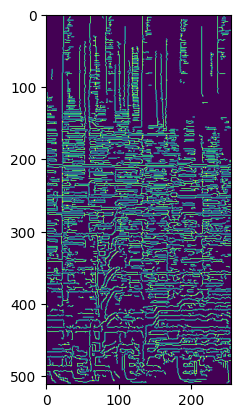

In [ ]:
first_256_frames = cv2.imread("/content/drive/MyDrive/Notebooks/EE 269 Final Project/full_Examples/" + str(i-1) + ".png")[:,256:]
first_256_frames = cv2.cvtColor(first_256_frames, cv2.COLOR_BGR2RGB)
first_256_frames_edges = cv.Canny(first_256_frames, 150, 200)
plt.imshow(first_256_frames_edges)

INFO:pytorch_lightning.utilities.seed:Global seed set to 14986


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:32<00:00,  3.04s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 37212


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 19170


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 51155


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 556


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.03s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 61967


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 8296


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 33027


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 49201


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.03s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 16545


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 97


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 25498


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 28695


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 59866


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.03s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 4453


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 10128


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 24497


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 13931


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 5077


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 24700


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 60433


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 14083


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [02:31<00:00,  3.03s/it]


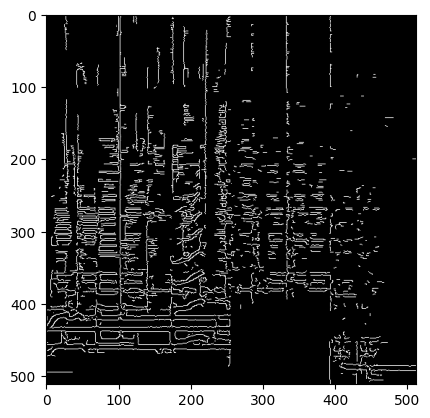

In [ ]:
for i in range(25, 47):
  #Get the first 256 frames from the previous wav file
  first_256_frames = cv2.imread("/content/drive/MyDrive/Notebooks/EE 269 Final Project/full_Examples/" + str(i-1) + ".png")[:,256:]
  first_256_frames = cv2.cvtColor(first_256_frames, cv2.COLOR_BGR2RGB)
  first_256_frames_edges = cv.Canny(first_256_frames, 150, 200)
  first_256_frames_edges = np.stack((first_256_frames_edges,first_256_frames_edges,first_256_frames_edges),axis=-1)

  #Get the the second 256 frames from the background edge map
  second_256_frames_edges = background_edges[:,(256+256*i):(512+256*i)]

  edges = np.concatenate((first_256_frames_edges,second_256_frames_edges),axis=1)
  plt.imshow(edges)
  

  results, _ = sample_ddim(edges, 'Generate an up-tempo female vocal rock melody', model, num_samples=4)
  sample = results[0]
  cv2.imwrite("/content/drive/MyDrive/Notebooks/EE 269 Final Project/full_Examples/" + str(i) + ".png", sample)
  timg_converter_to_audio = SpectrogramImageConverter(SpectrogramParams(sample_rate=44100, min_frequency=0, max_frequency=10000))
  sample_img = Image.open("/content/drive/MyDrive/Notebooks/EE 269 Final Project/full_Examples/" + str(i) + ".png")
  out_audio_recon = img_converter_to_audio.audio_from_spectrogram_image(sample_img, apply_filters=True).set_channels(2)
  out_audio_recon.export("/content/drive/MyDrive/Notebooks/EE 269 Final Project/full_Examples/"+str(i)+".wav", format="wav")
  out_audio_recon

  torch.cuda.empty_cache()
  del out_audio_recon
  del sample_img 
  del sample
  del results